![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Augmentation & Regularization </center>
### <center> Mixup </center>

Colab users should use GPU runtime:  
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/07_PyTorch2/MainPyTorchTensorBoard.ipynb)

In [2]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [6]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/Exercises/Ex4/DeepLearningFramework_Solution ./DeepLearningFramework_Solution
    !pip install torchinfo

In [7]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn               as nn
import torch.optim            as optim
import torchvision
import torchvision.transforms as transforms
import torchinfo

from torch.optim.lr_scheduler import OneCycleLR

torch.backends.cudnn.benchmark = True

### Load Fashion-MNIST data:

In [8]:
import torchvision
import torchvision.transforms as transforms

oTransform = transforms.Compose([
    transforms.ToTensor (),
    transforms.Normalize(0.5, 0.5)
])

DATA_PATH = '../../../data/'
oTrainSet = torchvision.datasets.FashionMNIST(DATA_PATH, download=True, train=True,  transform=oTransform)
oTestSet  = torchvision.datasets.FashionMNIST(DATA_PATH, download=True, train=False, transform=oTransform)

batchSize = 256
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, batch_size=1*batchSize, shuffle=True,  num_workers=2, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  batch_size=2*batchSize, shuffle=False, num_workers=2, persistent_workers=True)

lClasses  = oTrainSet.classes

#### Plot some examples:

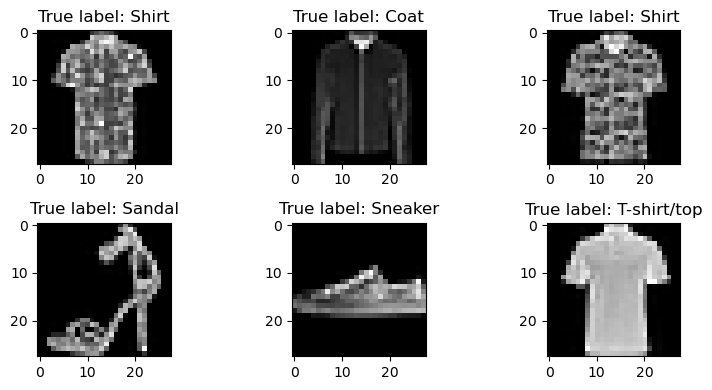

In [12]:
def Unnormalize(mX):
    return 0.5 * mX + 0.5

N, H, W = oTrainSet.data.shape
fig, _  = plt.subplots(2, 3, figsize=(8, 4))
for ax in fig.axes:
    idx   = np.random.randint(0, N)
    mX, y = oTrainSet[idx]
    mX    = Unnormalize(mX[0])
    mX    = torch.clamp(mX, 0, 1)
    ax.imshow   (mX, cmap='gray')
    ax.set_title(f'True label: {lClasses[y]}')
    
plt.tight_layout()
plt.show        ()

#### Define a model:

In [13]:
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def InitWeights(oModule):
    if isinstance(oModule, nn.Conv2d):
        nn.init.kaiming_normal_(oModule.weight.data)
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
#-- Model:
def GetModel():
    oModel = nn.Sequential(
        nn.Identity(), #-- does nothing
        
        nn.Conv2d(1,   32,  9, bias=False), nn.BatchNorm2d(32 ), nn.LeakyReLU(),
        nn.Conv2d(32,  64,  7, bias=False), nn.BatchNorm2d(64 ), nn.LeakyReLU(),
        nn.Conv2d(64,  64,  5, bias=False), nn.BatchNorm2d(64 ), nn.LeakyReLU(),
        nn.Conv2d(64,  128, 5, bias=False), nn.BatchNorm2d(128), nn.LeakyReLU(),
        nn.Conv2d(128, 128, 5, bias=False), nn.BatchNorm2d(128), nn.LeakyReLU(),
        
        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear (512, 10)
    )
    
    oModel.apply(InitWeights)
    
    return oModel

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
torchinfo.summary(GetModel(), (batchSize, 1, H, W))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Identity: 1-1                          [256, 1, 28, 28]          --
├─Conv2d: 1-2                            [256, 32, 20, 20]         2,592
├─BatchNorm2d: 1-3                       [256, 32, 20, 20]         64
├─LeakyReLU: 1-4                         [256, 32, 20, 20]         --
├─Conv2d: 1-5                            [256, 64, 14, 14]         100,352
├─BatchNorm2d: 1-6                       [256, 64, 14, 14]         128
├─LeakyReLU: 1-7                         [256, 64, 14, 14]         --
├─Conv2d: 1-8                            [256, 64, 10, 10]         102,400
├─BatchNorm2d: 1-9                       [256, 64, 10, 10]         128
├─LeakyReLU: 1-10                        [256, 64, 10, 10]         --
├─Conv2d: 1-11                           [256, 128, 6, 6]          204,800
├─BatchNorm2d: 1-12                      [256, 128, 6, 6]        

In [14]:
from DeepLearningFramework_Solution.Auxiliary import RandBox

def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    vLR         = np.full(nIter, np.nan)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU

    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(DEVICE)
        vY = vY.to(DEVICE)

        #-- Forward:
        if bTrain == True:
            #====================================================================================================#
            α    = 1
            λ    = np.random.beta(α, α)
            vIdx = torch.randperm(mX.shape[0], device=DEVICE)
            
            mX = λ * mX + (1 - λ) * mX[vIdx]
            # vY = λ * vY + (1 - λ) * vY[vIdx]
            
            mZ   = oModel(mX)
            loss = λ * Loss(mZ, vY) + (1 - λ) * Loss(mZ, vY[vIdx])
            #====================================================================================================#
            
            #-- Backward:
            oOptim.zero_grad() #-- set gradients to zeros
            loss.backward   () #-- backward
            oOptim.step     () #-- update parameters
            vLR[ii] = oScheduler.get_last_lr()[0]
            oScheduler.step() #-- update learning rate
            
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                mZ   = oModel(mX)
                loss = Loss  (mZ, vY)

        Nb           = vY.shape[0]
        count       += Nb
        epochLoss   += Nb * loss.item()
        if bTrain == True:
            epochMetric += Nb * (λ * Metric(mZ, vY) + (1 - λ) * Metric(mZ, vY[vIdx]))
        else:
            epochMetric += Nb * Metric(mZ, vY)
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric, vLR

In [15]:
import time

from DeepLearningFramework_Solution.Metric import Accuracy

def TrainClassficationModel(oModel, oTrainData, oValData, Loss, nEpochs, oOptim, oScheduler=None):

    vTrainLoss = np.full(nEpochs, np.nan)
    vTrainAcc  = np.full(nEpochs, np.nan)
    vValLoss   = np.full(nEpochs, np.nan)
    vValAcc    = np.full(nEpochs, np.nan)
    vLR        = np.full(0,       np.nan)
    bestAcc    = 0

    for epoch in range(nEpochs):
        startTime                 = time.time()
        trainLoss, trainAcc, vLRi = Epoch(oModel, oTrainData, Loss, Accuracy, oOptim, oScheduler, bTrain=True ) #-- train
        valLoss,   valAcc,   _    = Epoch(oModel, oValData,   Loss, Accuracy,                     bTrain=False) #-- validate
        epochTime                 = time.time() - startTime

        #-- Display:
        print('Epoch '              f'{epoch    :03d}:',   end='')
        print(' | Train loss: '     f'{trainLoss:.5f}' ,   end='')
        print(' | Val loss: '       f'{valLoss  :.5f}' ,   end='')
        print(' | Train Accuracy: ' f'{trainAcc :2.4f}',   end='')
        print(' | Val Accuracy: '   f'{valAcc   :2.4f}',   end='')
        print(' | epoch time: '     f'{epochTime:6.3f} |', end='')

        vTrainLoss[epoch] = trainLoss
        vTrainAcc [epoch] = trainAcc
        vValLoss  [epoch] = valLoss
        vValAcc   [epoch] = valAcc
        vLR               = np.concatenate([vLR, vLRi])

        #-- Save best model (early stopping):
        if bestAcc < valAcc:
            bestAcc = valAcc
            try:
                torch.save(oModel.state_dict(), 'BestModel.pt')
            except:
                pass
            print(' <-- Checkpoint!')
        else:
            print('')

    #-- Load best model (early stopping):
    oModel.load_state_dict(torch.load('BestModel.pt'))

    return vTrainLoss, vTrainAcc, vValLoss, vValAcc, vLR

#### Device:

In [16]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
DEVICE

device(type='cuda', index=0)

In [17]:
from torch.optim import lr_scheduler

nEpochs = 50
nIter   = nEpochs * len(oTrainDL)
Loss    = nn.CrossEntropyLoss()

oModel        = GetModel               ().to(DEVICE)
oOptim        = optim.Adam             (oModel.parameters(), lr=0, betas=(0.9, 0.99))
oScheduler    = lr_scheduler.OneCycleLR(oOptim, max_lr=5e-3, total_steps=nIter)
lHistory      = TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim, oScheduler)

Epoch 000: | Train loss: 1.26661 | Val loss: 0.54949 | Train Accuracy: 0.5809 | Val Accuracy: 0.8244 | epoch time:  6.970 | <-- Checkpoint!
Epoch 001: | Train loss: 1.03614 | Val loss: 0.44070 | Train Accuracy: 0.6458 | Val Accuracy: 0.8595 | epoch time:  3.796 | <-- Checkpoint!
Epoch 002: | Train loss: 0.96452 | Val loss: 0.42914 | Train Accuracy: 0.6613 | Val Accuracy: 0.8684 | epoch time:  3.793 | <-- Checkpoint!
Epoch 003: | Train loss: 0.91208 | Val loss: 0.40729 | Train Accuracy: 0.6760 | Val Accuracy: 0.8767 | epoch time:  3.786 | <-- Checkpoint!
Epoch 004: | Train loss: 0.92324 | Val loss: 0.43141 | Train Accuracy: 0.6682 | Val Accuracy: 0.8634 | epoch time:  3.763 |
Epoch 005: | Train loss: 0.89493 | Val loss: 0.39413 | Train Accuracy: 0.6747 | Val Accuracy: 0.8724 | epoch time:  3.741 |
Epoch 006: | Train loss: 0.87901 | Val loss: 0.38423 | Train Accuracy: 0.6775 | Val Accuracy: 0.8840 | epoch time:  3.760 | <-- Checkpoint!
Epoch 007: | Train loss: 0.88141 | Val loss: 0.39668

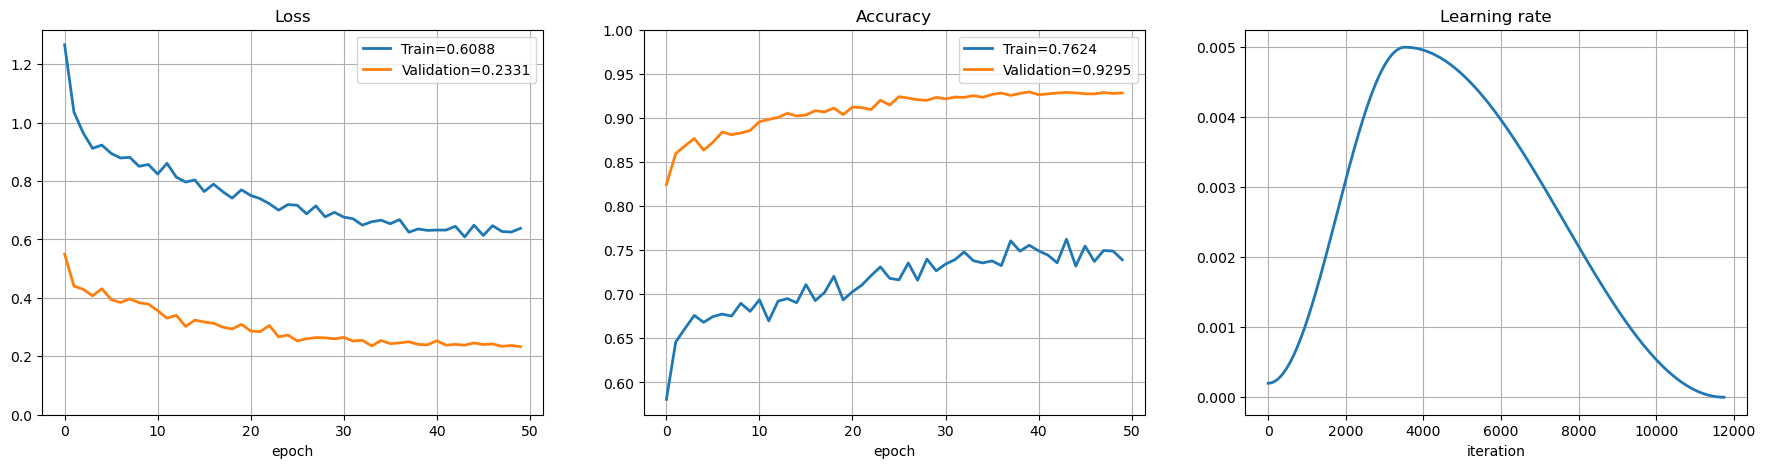

In [18]:
from DeepLearningFramework_Solution.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()